In [1]:
from matplotlib import scale
from numpy.lib.arraypad import pad
from numpy.lib.utils import source
import pandas as pd
import cv2
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def plot(src, warp, trg):
    '''plot stuff'''
    plt.figure(figsize=(8, 12))
    plt.subplot(3, 1, 1)
    plt.imshow(src)
    plt.title('src')
    plt.subplot(3, 1, 2)
    plt.imshow(warp)
    plt.title('warped')
    plt.subplot(3, 1, 3)
    plt.imshow(trg)
    plt.title('trg')
    plt.show()
    plt.close()

def Pad(img, padColor:int=255):

    if img.shape[0] > img.shape[1]:
        sh, sw = (img.shape[0], img.shape[0])
    else:
        sh, sw =(img.shape[1], img.shape[1])
    h, w = img.shape[:2]
    # sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    # scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    paddings = [pad_top, pad_bot, pad_left, pad_right]

    return scaled_img, paddings

def resizeAndPad(img, size=(256, 256), padColor:int=255, **kwargs):
    '''
    Function to resize images keeping the aspect ratio and then adding padding where neccessary to keep specified dimenstions

    Examples
    --------
    ```
    v_img = cv2.imread('v.jpg') # vertical image
    scaled_v_img = resizeAndPad(v_img, (200,200), 127)

    h_img = cv2.imread('h.jpg') # horizontal image
    scaled_h_img = resizeAndPad(h_img, (200,200), 127)

    sq_img = cv2.imread('sq.jpg') # square image
    scaled_sq_img = resizeAndPad(sq_img, (200,200), 127)
    ```
    '''
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [3]:
main_file_path = '../data/processed/edited_data_v2.csv'
root = '../data/raw/'

data = pd.read_csv(main_file_path, converters={'Source image size': lambda s: literal_eval(s),
                                               'Image size [pixels]': lambda s: literal_eval(s),
                                               'Source transformation matrix': lambda s: np.array(literal_eval(s))})

sources = data['Source image']
targets = data['Target image']
affine_transformations = data['Source transformation matrix'].to_numpy()

In [4]:
index = 34
path_source_img = os.path.join(root, sources[index])
path_target_img = os.path.join(root, targets[index])
source_img = cv2.imread(path_source_img)
target_img = cv2.imread(path_target_img)

In [5]:
# def pads(img):
#     paddings = resizeAndPad(img)
#     print(f'{paddings=}')
#     paddings = [pad/256 for pad in paddings]
#     paddings[2:] = [int(pad*img.shape[1]) for pad in paddings[2:]]
#     paddings[:2] = [int(pad*img.shape[0]) for pad in paddings[:2]]
#     return paddings
# 
# pads_src = pads(source_img)
# pads_trg = pads(target_img)

In [6]:
warped_src, pads_src = Pad(source_img)
# warped_trg, pads_trg = Pad(target_img)

In [7]:
warp_mat = affine_transformations[index].copy()
warp_mat[:, 2] /= 256
warp_mat[0, 2] *= warped_src.shape[1]
warp_mat[1, 2] *= warped_src.shape[0]

In [8]:
warped_src = cv2.warpAffine(warped_src, warp_mat, 
                            (warped_src.shape[1], warped_src.shape[0]), 
                            borderMode=cv2.BORDER_REPLICATE)

In [9]:
def unpad(img, paddings):
    return img[:, paddings[2]:-paddings[3], :]

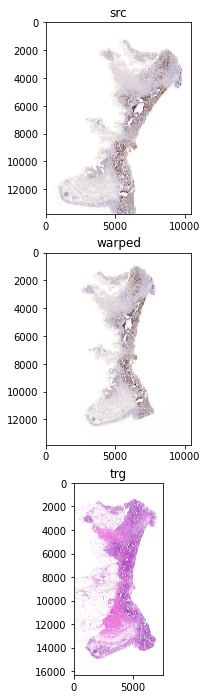

In [10]:
plot(source_img, unpad(warped_src, pads_src), target_img)

In [11]:
def adjust_images(img1, img2, padColor:int=255):
    hight = np.max([img1.shape[0], img2.shape[0]])
    width = np.max([img1.shape[1], img2.shape[1]])
    if len(img1.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    #img1
    img1_pads = calculate_paddings(hight, width, img1)
    img2_pads = calculate_paddings(hight, width, img2)

    img1_padded = cv2.copyMakeBorder(img1, borderType=cv2.BORDER_CONSTANT, value=padColor, **img1_pads)
    img2_padded = cv2.copyMakeBorder(img2, borderType=cv2.BORDER_CONSTANT, value=padColor, **img2_pads)

    return img1_padded, img2_padded, img1_pads, img2_pads
    
def calculate_paddings(hight, width, img):
    pad_vert = np.abs(hight - img.shape[0]) / 2
    pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
    pad_horz = np.abs(width - img.shape[1]) / 2
    pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)

    return {'top': pad_top, 'bottom': pad_bot, 'left': pad_left, 'right': pad_right}

def resample(img, size=(256, 256), padColor=255):
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
    else: # square image
        new_h, new_w = sh, sw

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    return scaled_img

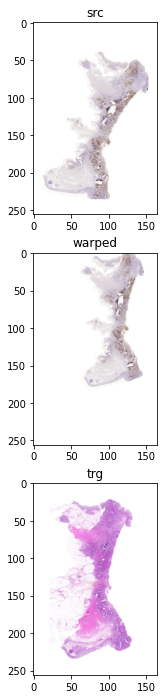

In [12]:
scaled_src, scaled_trg, _, _ = adjust_images(source_img, target_img)

warp_mat = affine_transformations[index].copy()
warp_mat[0, 2] = 0
warp_mat[1, 2] = 0
warped_src = cv2.warpAffine(scaled_src, warp_mat, 
                            (scaled_src.shape[1], scaled_src.shape[0]), 
                            borderMode=cv2.BORDER_REPLICATE)

# scaled_src = resample(scaled_src)
# scaled_trg = resample(scaled_trg)
# warped_src = resample(warped_src)

plot(resample(scaled_src), resample(warped_src), resample(scaled_trg))

In [13]:
dat = pd.read_csv('data.csv')

In [14]:
data

,Unnamed: 0,Image diagonal [pixels],Image size [pixels],Source image,Source landmarks,Target image,Target landmarks,status,Warped target landmarks,Warped source landmarks,Execution time [minutes],Source image size,Source transformation matrix
0,0,17997.0,"(16308, 7612)",COAD_01/scale-25pc/S1.jpg,COAD_01/scale-25pc/S1.csv,COAD_01/scale-25pc/HE.jpg,COAD_01/scale-25pc/HE.csv,evaluation,NaN,NaN,NaN,"(13812, 10496)","[[0.8018455014962457, 0.2751136651051479, -15...."
1,1,17997.0,"(16308, 7612)",COAD_01/scale-25pc/S3.jpg,COAD_01/scale-25pc/S3.csv,COAD_01/scale-25pc/HE.jpg,COAD_01/scale-25pc/HE.csv,evaluation,NaN,NaN,NaN,"(14131, 10724)","[[0.8566829853353113, -0.18554966456022187, 34..."
2,2,17997.0,"(16308, 7612)",COAD_01/scale-25pc/S6.jpg,COAD_01/scale-25pc/S6.csv,COAD_01/scale-25pc/HE.jpg,COAD_01/scale-25pc/HE.csv,evaluation,NaN,NaN,NaN,"(15052, 11381)","[[0.9391746800459613, -0.11148215119009704, 4...."
3,3,17997.0,"(16308, 7612)",COAD_01/scale-25pc/S7.jpg,COAD_01/scale-25pc/S7.csv,COAD_01/scale-25pc/HE.jpg,COAD_01/scale-25pc/HE.csv,evaluation,NaN,NaN,NaN,"(14727, 12634)","[[0.8756891100654379, -0.3056693741647162, 51...."
4,4,17347.5,"(13812, 10496)",COAD_01/scale-25pc/S3.jpg,COAD_01/scale-25pc/S3.csv,COAD_01/scale-25pc/S1.jpg,COAD_01/scale-25pc/S1.csv,training,NaN,NaN,NaN,"(14131, 10724)","[[0.8828820026334787, -0.5576267559679841, 79...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,476,11597.3,"(7040, 9216)",mice-kidney_1/scale-25pc/5_PAS.jpg,mice-kidney_1/scale-25pc/5_PAS.csv,mice-kidney_1/scale-25pc/7_PAS.jpg,mice-kidney_1/scale-25pc/7_PAS.csv,evaluation,NaN,NaN,NaN,"(8704, 11264)","[[1.2441822266637228, -0.08137056167689688, -1..."
477,477,11597.3,"(7040, 9216)",mice-kidney_1/scale-25pc/6_CD31.jpg,mice-kidney_1/scale-25pc/6_CD31.csv,mice-kidney_1/scale-25pc/7_PAS.jpg,mice-kidney_1/scale-25pc/7_PAS.csv,evaluation,NaN,NaN,NaN,"(8768, 8192)","[[0.9303624835660937, 0.349781560423628, -34.9..."
478,478,11597.3,"(7040, 9216)",mice-kidney_1/scale-25pc/8_CD31.jpg,mice-kidney_1/scale-25pc/8_CD31.csv,mice-kidney_1/scale-25pc/7_PAS.jpg,mice-kidney_1/scale-25pc/7_PAS.csv,evaluation,NaN,NaN,NaN,"(9152, 11264)","[[1.248192631509424, 0.15490786209268612, -47...."
479,479,11597.3,"(7040, 9216)",mice-kidney_1/scale-25pc/9_PAS.jpg,mice-kidney_1/scale-25pc/9_PAS.csv,mice-kidney_1/scale-25pc/7_PAS.jpg,mice-kidney_1/scale-25pc/7_PAS.csv,evaluation,NaN,NaN,NaN,"(7360, 9216)","[[1.000918910205674, 0.14722340858464233, -25...."


In [15]:
dat

,Unnamed: 0,source_tri_points,target_tri_points
0,0,"[[40.83511586, 432.02287582], [201.46256684, 4...","[[96.58318479, 452.9379085], [237.1322044, 365..."


In [16]:
dat['source_tri_points']

0    [[40.83511586, 432.02287582], [201.46256684, 4...
Name: source_tri_points, dtype: object

In [17]:
dat['source_tri_points'][0]

'[[40.83511586, 432.02287582], [201.46256684, 414.45424837], [152.10308972, 126.66339869], [289.3057041, 174.3496732]]'

In [18]:
type(dat['source_tri_points'][0])

str

In [19]:
literal_eval(dat['source_tri_points'][0])

[[40.83511586, 432.02287582],
 [201.46256684, 414.45424837],
 [152.10308972, 126.66339869],
 [289.3057041, 174.3496732]]

In [20]:
type(literal_eval(dat['source_tri_points'][0]))

list

In [21]:
np.array((literal_eval(dat['source_tri_points'][0])))

array([[ 40.83511586, 432.02287582],
       [201.46256684, 414.45424837],
       [152.10308972, 126.66339869],
       [289.3057041 , 174.3496732 ]])

In [22]:
np.array((literal_eval(dat['source_tri_points'][0]))).shape

(4, 2)

In [23]:
src_p = np.array((literal_eval(dat['source_tri_points'][0])))

In [24]:
trg_p = np.array((literal_eval(dat['target_tri_points'][0])))

In [10]:
def least_squares_transform(primary, secondary, print=False):

    # Pad the data with ones, so that our transformation can do translations too
    n = primary.shape[0]
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:,:-1]
    X = pad(primary)
    Y = pad(secondary)

    # Solve the least squares problem X * A = Y
    # to find our transformation matrix A
    A, res, rank, s = np.linalg.lstsq(X, Y)

    transform = lambda x: unpad(np.dot(pad(x), A))

    if print:
        print("Target:")
        print(secondary)
        print("Result:")
        print(transform(primary))
        print("Max error:", np.abs(secondary - transform(primary)).max())

    A[np.abs(A) < 1e-10] = 0 # set really small values to zero
    return A.T

In [26]:
least_squares_transform(src_p, trg_p)

C:\Users\arjur\AppData\Local\Temp/ipykernel_3572/2497968088.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(X, Y)


array([[  0.92757894,   0.32750338, -83.96876373],
       [ -0.38236991,   0.97644473,  42.62436043],
       [  0.        ,   0.        ,   1.        ]])

In [27]:
src_img = (cv2.imread(data_prepath+main_file['Source image'][0]))
trg_img = (cv2.imread(data_prepath+main_file['Target image'][0]))

NameError: name 'data_prepath' is not defined

In [6]:
save_path = 'data.csv'
main_file_path = '../data/processed/edited_data.csv'
data_prepath = '../data/processed/'

past_data = pd.read_csv(save_path)
main_file = pd.read_csv(main_file_path)
main_file['Source image size'] = [literal_eval(x) for x in main_file['Source image size']]
main_file['Image size [pixels]'] = [literal_eval(x) for x in main_file['Image size [pixels]']]

col = past_data['source_tri_points']
src_tri = np.array([literal_eval(x) for x in col], dtype=np.float32)

col = past_data['target_tri_points']
dst_tri = np.array([literal_eval(x) for x in col], dtype=np.float32)

In [7]:
src_tri

array([[[ 27.449495, 409.43463 ],
        [198.11617 , 454.6111  ],
        [277.5933  , 100.72876 ],
        [132.86127 , 104.075165]],

       [[127.99525 , 430.34967 ],
        [287.7861  , 369.27777 ],
        [215.83838 ,  53.879086],
        [ 81.98218 ,  91.526146]],

       [[143.85146 , 428.67648 ],
        [301.1325  , 374.2974  ],
        [268.50504 ,  74.79412 ],
        [101.18479 , 123.31699 ]],

       [[201.49852 , 450.4281  ],
        [316.9495  , 347.52615 ],
        [250.0214  ,  91.526146],
        [ 80.19132 ,  83.16013 ]],

       [[153.99524 , 462.14053 ],
        [332.1913  , 384.3366  ],
        [285.34164 ,  82.32353 ],
        [105.472374, 130.8464  ]],

       [[155.50505 , 441.2255  ],
        [329.51813 , 384.3366  ],
        [290.19788 ,  58.06209 ],
        [111.165184, 111.604576]],

       [[196.56387 , 462.9771  ],
        [350.4985  , 357.56537 ],
        [276.041   ,  73.95752 ],
        [ 77.76649 , 117.460785]],

       [[158.01485 , 442.0621  ],


In [15]:
warp_mat = least_squares_transform(src_tri[34], dst_tri[34])

C:\Users\arjur\AppData\Local\Temp/ipykernel_15384/2497968088.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(X, Y)


In [16]:
warp_mat

array([[  1.00327074,  -0.07985928,  10.94566199],
       [  0.07993233,   1.01955942, -25.00372289],
       [  0.        ,   0.        ,   1.        ]])

In [8]:
src_img = (cv2.imread(data_prepath+main_file['Source image'][34]))
trg_img = (cv2.imread(data_prepath+main_file['Target image'][34]))

In [12]:
src_img, trg_img, _, _ = adjust_images(src_img, trg_img)

In [13]:
src_img = (cv2.imread(data_prepath+main_file['Source image'][34]))
trg_img = (cv2.imread(data_prepath+main_file['Target image'][34]))

In [14]:
src_img, trg_img, src_pads, trg_pads = adjust_images(src_img, trg_img)

In [18]:
warp_dst = cv2.warpAffine(src_img, warp_mat[:2, :], 
                                (src_img.shape[1], src_img.shape[0]), 
                                borderMode=cv2.BORDER_CONSTANT, 
                                borderValue=(255, 255, 255))

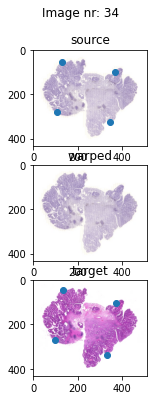

In [20]:
i = 34
fig = plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.imshow(src_img)
plt.scatter(src_tri[i][:, 0], src_tri[i][:, 1])
plt.title('source')
plt.subplot(3, 1, 2)
plt.imshow(warp_dst)
plt.title('warped')
plt.subplot(3, 1, 3)
plt.imshow(trg_img)
plt.scatter(dst_tri[i][:, 0], dst_tri[i][:, 1])
plt.title('target')
fig.suptitle(f'Image nr: {i}')
plt.show()
plt.close()

In [21]:
src_img.shape

(432, 512, 3)

In [22]:
src_img = (cv2.imread(data_prepath+main_file['Source image'][34]))
trg_img = (cv2.imread(data_prepath+main_file['Target image'][34]))

In [23]:
src_img.shape

(417, 512, 3)

In [24]:
data_prepath = '../data/raw/'

In [25]:
src_img = (cv2.imread(data_prepath+main_file['Source image'][34]))
trg_img = (cv2.imread(data_prepath+main_file['Target image'][34]))

In [26]:
src_img.shape

(8064, 9911, 3)

In [27]:
src_img, trg_img, src_pads, trg_pads = adjust_images(src_img, trg_img)

In [28]:
src_img.shape

(8381, 9923, 3)

In [29]:
warp_dst = cv2.warpAffine(src_img, warp_mat[:2, :], 
                                (src_img.shape[1], src_img.shape[0]), 
                                borderMode=cv2.BORDER_CONSTANT, 
                                borderValue=(255, 255, 255))

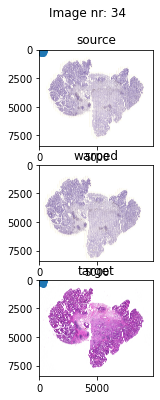

In [30]:
i = 34
fig = plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.imshow(src_img)
plt.scatter(src_tri[i][:, 0], src_tri[i][:, 1])
plt.title('source')
plt.subplot(3, 1, 2)
plt.imshow(warp_dst)
plt.title('warped')
plt.subplot(3, 1, 3)
plt.imshow(trg_img)
plt.scatter(dst_tri[i][:, 0], dst_tri[i][:, 1])
plt.title('target')
fig.suptitle(f'Image nr: {i}')
plt.show()
plt.close()

In [31]:
warp_mat

array([[  1.00327074,  -0.07985928,  10.94566199],
       [  0.07993233,   1.01955942, -25.00372289],
       [  0.        ,   0.        ,   1.        ]])

In [32]:
warp_mat[:2, 2]

array([ 10.94566199, -25.00372289])

In [33]:
t = resample(src_img, 512)

TypeError: cannot unpack non-iterable int object

In [34]:
t = resample(src_img, (512, 512))

In [35]:
t.shape

(432, 512, 3)

In [36]:
warp_mat[0, 2]

10.945661993697614

In [37]:
warp_mat_c = warp_mat.copy()

In [38]:
warp_mat_c[0, 2]

10.945661993697614

In [39]:
warp_mat_c[0, 2] /= 512

In [40]:
warp_mat_c[0, 2] *= 9923

In [41]:
warp_mat_c[1, 2]

-25.00372289480037

In [42]:
warp_mat_c[1, 2] /= 432

In [43]:
warp_mat_c[1, 2] *= 8064

In [44]:
warp_dst = cv2.warpAffine(src_img, warp_mat_c[:2, :], 
                                (src_img.shape[1], src_img.shape[0]), 
                                borderMode=cv2.BORDER_CONSTANT, 
                                borderValue=(255, 255, 255))

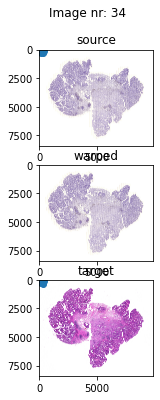

In [45]:
i = 34
fig = plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.imshow(src_img)
plt.scatter(src_tri[i][:, 0], src_tri[i][:, 1])
plt.title('source')
plt.subplot(3, 1, 2)
plt.imshow(warp_dst)
plt.title('warped')
plt.subplot(3, 1, 3)
plt.imshow(trg_img)
plt.scatter(dst_tri[i][:, 0], dst_tri[i][:, 1])
plt.title('target')
fig.suptitle(f'Image nr: {i}')
plt.show()
plt.close()

In [48]:
src_pads

{'top': 158, 'bottom': 159, 'left': 6, 'right': 6}

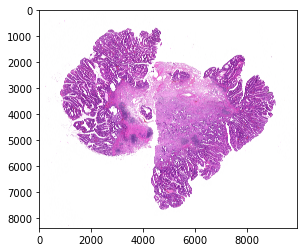

In [49]:
plt.imshow(trg_img[trg_pads['left']:,:])

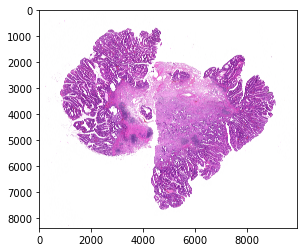

In [50]:
plt.imshow(trg_img[:, trg_pads['left']:])

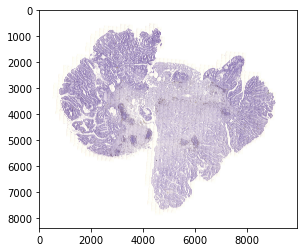

In [51]:
plt.imshow(warp_dst[:, trg_pads['left']:])